# Dataset (Dota2)

## Source
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

Dataset Full Name : Dota2 Games Results Data Set 

## Description
Each row of the dataset is a single game with the following features (in the order in the vector):
0. Team won the game (1 or -1)
1. Cluster ID (related to location)
2. Game mode (eg All Pick)
3. Game type (eg. Ranked)
4. ~end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.

---
# Goal : Predict win or lose (Classification)

---
# Init

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

---
# Data

In [3]:
train = pd.read_csv('data/dota2Train.csv', header=None)
train.info()
print(f'\nTotal NA count: {train.isna().sum().sum()}')
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92650 entries, 0 to 92649
Columns: 117 entries, 0 to 116
dtypes: int64(117)
memory usage: 82.7 MB

Total NA count: 0


,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv('data/dota2Test.csv', header=None)
test.info()
print(f'\nTotal NA count: {train.isna().sum().sum()}')
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10294 entries, 0 to 10293
Columns: 117 entries, 0 to 116
dtypes: int64(117)
memory usage: 9.2 MB

Total NA count: 0


,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


---
# Analysis

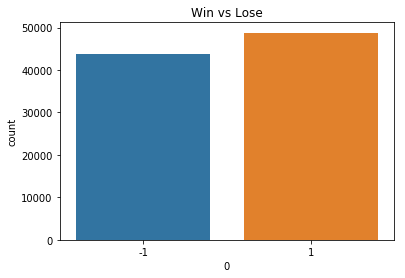

In [5]:
ax = sns.countplot(train[0]);
ax.set_title('Win vs Lose');

## Note
***Positive part in the graphs below represents win count, Negative part represents lose count***

In [6]:
win_group = train[train[0]>0]
lose_group = train[train[0]<0]

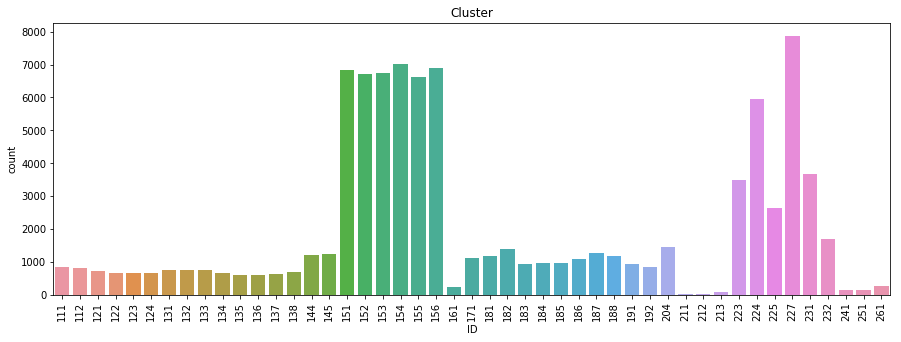

In [7]:
plt.figure(figsize=(15,5))

ax = sns.countplot(train[1])
ax.set_title('Cluster')
ax.set_xlabel('ID')
plt.xticks(rotation=90);

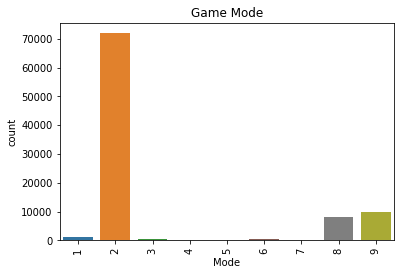

In [8]:
ax = sns.countplot(train[2])
ax.set_title('Game Mode')
ax.set_xlabel('Mode')
plt.xticks(rotation=90);

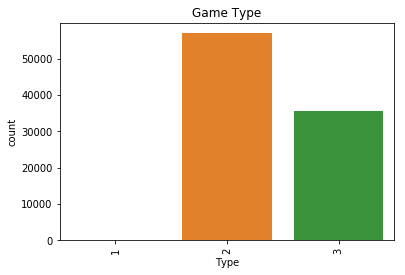

In [9]:
ax = sns.countplot(train[3])
ax.set_title('Game Type')
ax.set_xlabel('Type')
plt.xticks(rotation=90);

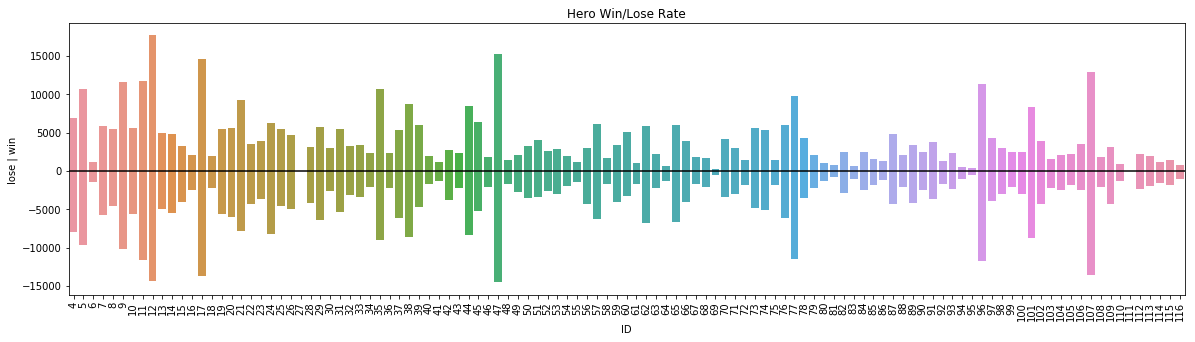

In [10]:
plt.figure(figsize=(20,5))
heroes = train.loc[:,4:]

w = train[train[0]>0].loc[:,4:]
l = train[train[0]<0].loc[:,4:]

ax = sns.barplot(x=heroes.columns, y=w[w>0].sum()+l[l<0].sum()*-1)
ax = sns.barplot(x=heroes.columns, y=w[w<0].sum()+l[l>0].sum()*-1)
ax.set_title('Hero Win/Lose Rate')
ax.set_xlabel('ID')
ax.set_ylabel('lose | win ')
plt.xticks(rotation=90)
plt.axhline(0, color='black');

## Observation/Inference
- Some features are unbalanced.
- To predict game result, features that are the same for both sides should not be used.
- Using the field of heroes to predict game result seems most viable.

---
# Direct Approach (original data)
## Preprocessing

In [11]:
def preprocess_data_original(data):
    df = data.copy(deep=True)
    # Rename columns
    mapper = {
        0: 'Win',
        1: 'Location',
        2: 'Mode',
        3: 'Type'
    }
    n = len(mapper)
    mapper.update({i:f'Hero_{i-n}' for i in range(n, len(df.columns))})
    df.rename(mapper=mapper, axis=1, inplace=True)
    # Drop columns
    df.drop(['Location', 'Mode', 'Type'], axis=1, inplace=True)
#     df = df.applymap(lambda x: 0 if x==-1 else 0.5 if x==0 else 1)
    return df.drop('Win', axis=1), df.Win

In [12]:
x_train, y_train = preprocess_data_original(train)
x_test, y_test = preprocess_data_original(test)

## Train & Test

In [13]:
def train_test_original(epochs=1, batch_size=16):
    input_shape = [len(x_train.columns)]

    model = models.Sequential([
        layers.Dense(1, activation=tf.nn.softmax, input_shape=input_shape),
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # train the parameters
    history = model.fit(x_train,
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)
    train_acc = history.history['acc'][-1]

    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    
    return train_acc, test_acc

In [14]:
orig_train_acc, orig_test_acc = train_test_original(epochs=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
92650/92650 [==============================] - 7s 72us/sample - loss: 15.0968 - acc: 0.5265
Epoch 2/2
10294/10294 [==============================] - 0s 39us/sample - loss: 14.8428 - acc: 0.5345


---
# Reflection on direct approach

## Data
> - Heroes on friendly team are not exact opposite of those on the enemy team. Features like this should not share weights.

## Model
> - Use **sparse_categorical_crossentropy** instead of **binary_crossentropy**

---
# Adjusted approach (Separated teams & Change loss method)

## Preprocessing

In [15]:
def preprocess_data_new(data):
    df = data.copy(deep=True)
    # Divide into two teams
    teams = df.loc[:, 4:]
    n = len(teams.columns)
    team_A = teams.applymap(lambda x: 1 if x>0 else 0)
    team_A.columns = [f'Team_A_{i}' for i in range(n)]
    team_B = teams.applymap(lambda x: 1 if x<0 else 0)
    team_B.columns = [f'Team_B_{i}' for i in range(n)]
    # Merge
    x = pd.concat([team_A, team_B], axis=1)
    y = df.loc[:, 0].apply(lambda x: 1 if x>0 else 0)
    return x, y

In [16]:
x_train, y_train = preprocess_data_new(train)
x_test, y_test = preprocess_data_new(test)

# Train & Test

In [17]:
def train_test_new(epochs=1, batch_size=16):
    input_shape = [len(x_train.columns)]
    output_dim = len(y_train.unique())

    model = models.Sequential([
        layers.Dense(output_dim, activation=tf.nn.softmax, input_shape=input_shape),
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # train the parameters
    history = model.fit(x_train,
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)
    train_acc = history.history['acc'][-1]

    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    
    return train_acc, test_acc

In [18]:
new_train_acc, new_test_acc = train_test_new(epochs=2)

Epoch 1/2
92650/92650 [==============================] - 6s 68us/sample - loss: 0.6704 - acc: 0.5843
Epoch 2/2
10294/10294 [==============================] - 0s 38us/sample - loss: 0.6624 - acc: 0.5933


---
# Result

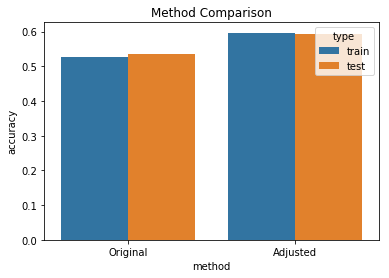

In [19]:
data = [
    [orig_train_acc, 'train', 'Original'],
    [orig_test_acc, 'test', 'Original'],
    [new_train_acc, 'train', 'Adjusted'],
    [new_test_acc, 'test', 'Adjusted']
]
result = pd.DataFrame(data, columns = ['accuracy', 'type', 'method'])

ax = sns.barplot(x='method', y='accuracy', hue='type', data=result)
ax.set_title('Method Comparison');